In [5]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
import math
import pandas as pd
from tqdm import tqdm
from Aero_info import *

# Баллистическое проектирование ЗУР

## 1) Первоначальный баллистический расчет
Для начала проинтегрируем систему, приняв угол склонения ракеты **thetta (Q)** постоянным на активном участке полета. Для этого используем упрощенную систему уравнений движения ракеты [*пособие Астахова "Бал. пр-е", система ур-ний (4)*], где все переменные коэф-ты выраженны через проектные параметры ракеты, при **alpha = 0**, следовательно, и **Cya = 0**. Найдем минимум стартовой массы ракеты (перебором относительной массы топливного заряда при заданном коэф-те конструктивно-массового совершенства и массе полезной нагрузки из прототипа). Получим в итоге профиль скорости нашей ЗУР, который будет использован в первоначальном АД проектировании для получения коэф-тов Суа от числа М, и Сх от alpha и числа М. Далее будем использовать исходную полную систему уравнений движения [*Физ. основы устр-ва ракетного оружия, глава 3*] для уточнения баллистического расчёта и дальнешего АД расчета.

### 1.1. Простая прогонка с параметрами прототипа

In [6]:
alpha, Cy_alpha = 0, 0

In [7]:
# Пример формирования словаря с начальными данными одноступенчатой ракеты (аналог - ЗУР 48Н6E ЗРС С-300 ПМУ-1)
opts = {
    'init_conditions': {'l_pusk': 8,
                        'x': 0,
                        'y': 50,
                        'v': 25,
                        'thetta': 35},
    'η_0': 14,
    'I_10': 2700,
    'myu_0': 0.59,
    'lambda_e': 2.373,
    'k': 1.21,
    'p_00': 5*1e6,
    'q_M': 2400 * 9.80665 / (np.pi * 0.515**2 / 4),
    'i': 1.2,
    'integr': {'stop_conditions': 'x_max',
               'value': 2e5,
               'dt': 1e-1}
}  

In [8]:
def ozvb(dict_opts):
    
    """
    Ф-ция решения прямой задачи внешней баллистики (ОЗВБ) ракеты
    argument:  dict_opts {dict}  -- словарь с опциями (начальными данными)
    return:    dict_res  {dict}  -- словарь с результатами решения ОЗВБ
    """
    
    # const:
    g     = 9.80665
    p_h0  = 101325
    k_air = 1.41
    
    def func_stop(stop_conditions):
        if stop_conditions == 't0':
            return lambda t: dict_opts['I_10'] * dict_opts['myu_0'] / dict_opts['η_0'] / g - t
        if stop_conditions == 'v_max':
            return lambda v: dict_opts['integr']['value'] - v
        if stop_conditions == 'y_max':
            return lambda y: dict_opts['integr']['value'] - y
        if stop_conditions == 'x_max':
            return lambda x: dict_opts['integr']['value'] - x
        if stop_conditions == 'step_max':
            return lambda i: dict_opts['integr']['value'] - i
        if stop_conditions == 't_max':
            return lambda t: dict_opts['integr']['value'] - t

    def f(λ, k):
        # табличная газодинамическая функция
        return (1 + λ ** 2) * (1 - ((k - 1) / (k + 1)) * λ ** 2) ** (1 / (k - 1))

    def π(y):
        # ф-ция изменения атмосф. давления с высотой
        p_h = table_atm(y, 2)
        return p_h / p_h0

    def ξ_stage(μ, μ_0):
        # ф-ция, учитывающая отстыковку стартовой ступени (для двухступенчатых ракет)
        if μ < μ_0:
            return 1
        else:
            return 0
   
    def ξ_pusk(x, y):
        # ф-ция, учитывающая неизменность угла наклона траектории при движении ракеты по направляющей
        if np.sqrt(x ** 2 + y ** 2) <= dict_opts['init_conditions']['l_pusk']:
            return 0
        else:
            return 1

    def system(t, Y, r=dict_opts, Cx=Cx43):
            
        y1 = Y[0] # v
        y2 = Y[1] # θ
        y3 = Y[2] # x
        y4 = Y[3] # y
        y5 = Y[4] # μ 
        
        M  = y1 / table_atm(y4, 4)
        
        a10_1 = g * r['η_0'] / (1 - y5)
        a10_2 = g * r['η_0'] * (1 - π(y4)) / ((f(r['lambda_e'], r['k']) * (r['p_00'] / p_h0) - 1) * (1 - y5))
        a1_3  = g * r['i'] * Cx(M) * k_air * p_h0 * π(y4) * (M ** 2) / (2 * r['q_M'] * (1 - y5))
        a1_4  = g * np.sin(y2)
        
        # dv/dt
        f1 = (a10_1 + a10_2) * ξ_stage(y5, r['myu_0']) - a1_3 - a1_4
        # dθ/dt
        f2 = g * ξ_pusk(y3, y4) / (y1 ** (ξ_pusk(y3, y4))) * (Cy_alpha * alpha * table_atm(y4, 3) * y1 ** 2 / (2 * r['q_M'] * (1 - y5)) + r['η_0'] * np.sin(np.radians(alpha)) / (1 - y5) - np.cos(y2) * (1 - ξ_stage(y5, r['myu_0'])))
        # dx/dt
        f3 = y1 * np.cos(y2)
        # dy/dt
        f4 = y1 * np.sin(y2)
        # dμ/dt
        f5 = g * (r['η_0'] / r['I_10']) * ξ_stage(y5, r['myu_0'])
        
        return np.array([f1, f2, f3, f4, f5])
   
    def RK4(F, Y0, stop_conditions=dict_opts['integr']['stop_conditions'],
            func_end=func_stop(dict_opts['integr']['stop_conditions']), 
            dt=dict_opts['integr']['dt'], y=dict_opts['init_conditions']['y'],
            t0=0, max_time=300): 
        
        ti = t0 
        Yi = Y0
        res = {
        'y1': [Y0[0]],
        'y2': [Y0[1]],
        'y3': [Y0[2]],
        'y4': [Y0[3]],
        'y5': [Y0[4]],
        'Mach': [Y0[0]/table_atm(Y0[3],4)],
        't': [t0],
        'stop_reason': ''        
        }

        def foo_init_stop(stop_conditions, fint, *args):
            if stop_conditions == 't0':
                if fint == 1:
                    return args[1]
                if fint == 0:
                    return t0
            elif stop_conditions == 'v_max':
                if fint == 1:
                    return args[0][0]
                if fint == 0:
                    return Y0[0]
            elif stop_conditions == 'y_max':
                if fint == 1:
                    return args[0][3]
                if fint==0:
                    return Y0[3]
            elif stop_conditions == 'x_max':
                if fint == 1:
                    return args[0][2]
                if fint == 0:
                    return Y0[2]
            elif stop_conditions == 't_max':
                if fint == 1:
                    return args[1]
                if fint == 0:
                    return t0
            else:
                print('unknown condition')
        
        flag = True
        var = foo_init_stop(stop_conditions, 0, Yi, ti)
        
        while func_end(var) > 0 and ti < max_time and Yi[3] < 8e4 and flag == True:
            
            k1 = F(ti, Yi)
            k2 = F(ti + dt / 2, Yi + k1 * dt / 2)
            k3 = F(ti + dt / 2, Yi + k2 * dt / 2)
            k4 = F(ti + dt, Yi + k3 * dt)
            Yi += dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6
            
            ti += dt
            if Yi[3] <= 0:
                flag = False
            
            var = foo_init_stop(stop_conditions, 1, Yi, ti)
            
            res['y1'].append(Yi[0])
            res['y2'].append(Yi[1])
            res['y3'].append(Yi[2])
            res['y4'].append(Yi[3])
            res['y5'].append(Yi[4])
            res['Mach'].append(Yi[0]/table_atm(Yi[3],4))
            res['t'].append(ti)
            
        if func_end(var) < 0:
            stop_reason = dict_opts['integr']['stop_conditions']
        elif ti >= max_time:
            stop_reason = 'max_time'
        elif Yi[3] <= 0:
            stop_reason = f'missile arrived (x = {Yi[2]}; y = 0)'
        elif Yi[3] >= 8e4:
            stop_reason = 'y_max_atmo'
        else:
            stop_reason = 'unknown reason'
        res['stop_reason'] = stop_reason
        print(f'stop reason: {stop_reason};\nflight time: {ti} с.;')
        
        return res
    
    init = [dict_opts['init_conditions']['v'], np.radians(dict_opts['init_conditions']['thetta']),
            dict_opts['init_conditions']['x'], dict_opts['init_conditions']['y'], 0]
    
    fl_start = timeit.default_timer()
    res = RK4(system, init)
    fl_end   = timeit.default_timer() - fl_start 
    print(f'execution time: {fl_end} с.')
    
    dict_res = {
        'v': np.array(res['y1']),
        'thetta': np.array(res['y2']),
        'x':  np.array(res['y3']),
        'y': np.array(res['y4']),
        'myu':  np.array(res['y5']),
        't':  np.array(res['t']),
        'Mach': np.array(res['Mach']),
        'stop_reason': res['stop_reason'],
        'execution_time': fl_end
    }

    return dict_res

In [5]:
res = ozvb(opts)

stop reason: x_max;
flight time: 150.0 с.;
execution time: 35.2462417 с.


In [6]:
%matplotlib inline

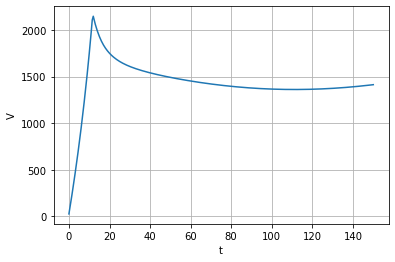

In [7]:
plt.figure()
plt.plot(res['t'], res['v'])
plt.grid()
plt.xlabel('t'), plt.ylabel('V') 
plt.show()

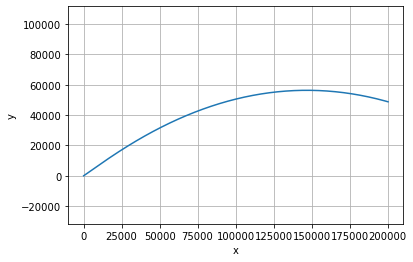

In [8]:
plt.figure()
plt.plot(res['x'], res['y'])
plt.xlabel('x'), plt.ylabel('y') 
plt.axis('equal')
plt.ylim(0, 8e4)
plt.grid()
plt.show()

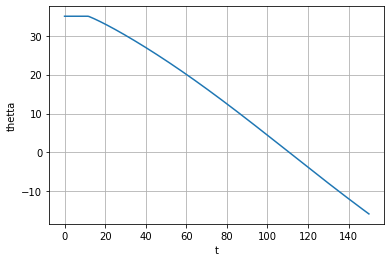

In [9]:
plt.figure()
plt.plot(res['t'], np.degrees(res['thetta']))
plt.xlabel('t'), plt.ylabel('thetta') 
plt.grid()
plt.show()

### 1.2. Поиск оптимального начального угла склонения ракеты Q0

In [82]:
mass_thetta = np.arange(20, 65, 5)
mass_y_end  = []
mass_x_end  = []
mass_stop   = []
for i in mass_thetta:
    opts['init_conditions']['thetta'] = i
    res = ozvb(opts)
    mass_y_end.append(res['y'][-1])
    mass_x_end.append(res['x'][-1])
    mass_stop.append(res['stop_reason'])  
mass_y_end = np.array(mass_y_end)
mass_x_end = np.array(mass_x_end)

stop reason: missile arrived (x = 117460.73226050592; y = 0);
flight time: 122.0 с.;
execution time: 24.02381659999992 с.
stop reason: missile arrived (x = 169806.79770515338; y = 0);
flight time: 152.5 с.;
execution time: 29.090437299999394 с.
stop reason: x_max;
flight time: 155.0 с.;
execution time: 29.78911210000024 с.
stop reason: x_max;
flight time: 150.0 с.;
execution time: 30.675045099999807 с.
stop reason: x_max;
flight time: 151.5 с.;
execution time: 22.511136299999635 с.
stop reason: y_max_atmo;
flight time: 86.0 с.;
execution time: 10.636283899999398 с.
stop reason: y_max_atmo;
flight time: 71.0 с.;
execution time: 8.800911499999529 с.
stop reason: y_max_atmo;
flight time: 63.0 с.;
execution time: 7.748707700000523 с.
stop reason: y_max_atmo;
flight time: 57.5 с.;
execution time: 7.378527799999574 с.


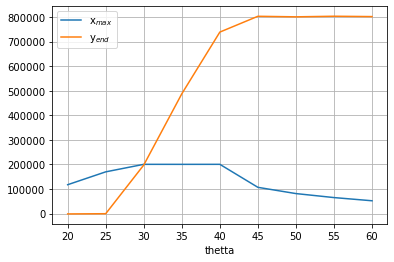

In [83]:
plt.figure()
plt.plot(mass_thetta, mass_x_end, label='x$_{max}$')
plt.plot(mass_thetta, mass_y_end*1e1, label='y$_{end}$')
plt.xlabel('thetta')
plt.legend()
plt.grid()
plt.show()

In [84]:
y_end_max = mass_y_end[0]
for i in range(len(mass_x_end)):
    if mass_stop[i] == 'x_max' and mass_y_end[i] > y_end_max and mass_y_end[i] < 35e3:
        thetta_opt = mass_thetta[i]
thetta_opt

30

In [10]:
thetta_opt = 35
opts['init_conditions']['thetta'] = thetta_opt

### 1.3. Поиск минимума стартовой массы ракеты

In [10]:
mass_μ_0 = np.arange(0.55, 0.66, 0.01)
m_пн = 730
α_д = 0.18

In [87]:
mass_m_0, mass_V_0, mass_myu_0 = [], [], []
for i in mass_μ_0:
    opts['myu_0'] = i
    m_0 = m_пн / (1 - (1 + α_д) * i)
    opts['q_M'] = m_0 * 9.80665 / (np.pi * 0.515**2 / 4)
    res = ozvb(opts)
    if res['stop_reason'] == 'x_max' and max(res['v']) > 2100:
        mass_m_0.append(m_0)
        mass_V_0.append(max(res['v']))
        mass_myu_0.append(i)

stop reason: x_max;
flight time: 180.0 с.;
execution time: 22.716152500000135 с.
stop reason: x_max;
flight time: 167.5 с.;
execution time: 20.846190500000375 с.
stop reason: x_max;
flight time: 165.0 с.;
execution time: 20.280075799999395 с.
stop reason: x_max;
flight time: 159.0 с.;
execution time: 19.86597569999958 с.
stop reason: x_max;
flight time: 150.0 с.;
execution time: 18.68132719999994 с.
stop reason: x_max;
flight time: 144.5 с.;
execution time: 17.926345900000342 с.
stop reason: x_max;
flight time: 138.0 с.;
execution time: 17.331655099999807 с.
stop reason: x_max;
flight time: 134.5 с.;
execution time: 17.033898699999554 с.
stop reason: x_max;
flight time: 130.0 с.;
execution time: 16.17027700000017 с.
stop reason: y_max_atmo;
flight time: 111.5 с.;
execution time: 13.935855199999423 с.
stop reason: y_max_atmo;
flight time: 97.5 с.;
execution time: 12.773819699999876 с.


In [12]:
ind_min, m_0_opt = np.argmin(mass_m_0), min(mass_m_0)
myu_0_opt = mass_myu_0[ind_min]
t_0 = opts['I_10'] * myu_0_opt / opts['η_0'] / 9.80665
print(f'Стартовая масса ракеты m0 = {m_0_opt} (μ = {myu_0_opt})')
print(f'Время работы ДУ t = {t_0}')

NameError: name 'mass_m_0' is not defined

### 1.4. Получаем профиль скорости и траекторию полёта

In [11]:
myu_0_opt = 0.59
m_0_opt = 2402.896642527979

In [12]:
opts['myu_0'] = myu_0_opt
opts['q_M'] = m_0_opt * 9.80665 / (np.pi * 0.515**2 / 4)
res = ozvb(opts)

stop reason: x_max;
flight time: 151.59999999999567 с.;
execution time: 161.33756589999996 с.


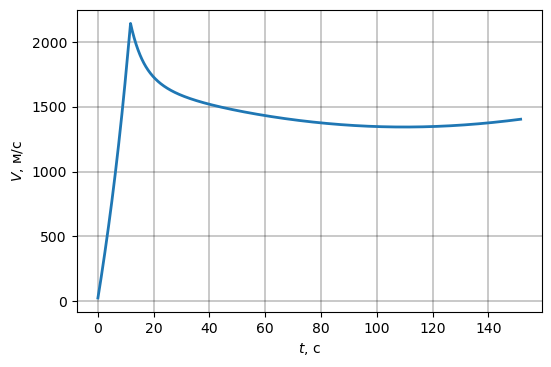

2142.117991372499

In [13]:
plt.figure(dpi=100)
plt.plot(res['t'], res['v'], linewidth=2)
plt.grid()
plt.xlabel('$t$, с'), plt.ylabel('$V$, м/с') 
plt.grid(True, linewidth=0.3, color='k')
plt.show()
max(res['v'])

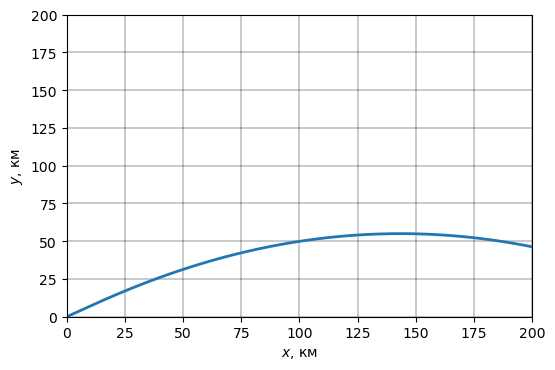

In [14]:
plt.figure(dpi=100)
plt.plot(res['x']/1e3, res['y']/1e3, linewidth=2)
plt.xlabel('$x$, км'), plt.ylabel('$y$, км') 
plt.xlim(0, 200), plt.ylim(0, 200)
plt.grid(True, linewidth=0.3, color='k')
plt.show()

In [15]:
g = 9.80665
m_0 = m_0_opt
m_бч = 145
d = 0.515 # из прототипа
gamma = 1500 # плотность ракеты по статистике (удельный вес)
q_m = (4 * m_0 * g) / (np.pi * d**2)
l_korp = m_0 / (np.pi * d**2 / 4 * gamma)
lambd_korp = l_korp / d
w_marsh = m_0 * myu_0_opt
t_marsh = opts['I_10'] * myu_0_opt / opts['η_0'] / g
G_marsh = w_marsh / t_marsh
P_marsh = opts['η_0'] * g * m_0 #  у прототипа 220000
print(f'Стартовая масса ракеты: m0 = {m_0} кг;')
print(f'Нагрузка на мидель на старте: q = {q_m} Н/м^2;')
print(f'Длина корпуса ракеты: l = {l_korp} м (длина ТПК 7810 мм);')
print(f'Удлинение корпуса ракеты: λ = {lambd_korp};')
print(f'Масса топлива двигателя: w = {w_marsh} кг;')
print(f'Время работы двигателя: t = {t_marsh} с;')
print(f'Расход топлива: G = {G_marsh} кг/с;')
print(f'Тяга ДУ: P = {P_marsh} Н;')

Стартовая масса ракеты: m0 = 2402.896642527979 кг;
Нагрузка на мидель на старте: q = 113123.13354877892 Н/м^2;
Длина корпуса ракеты: l = 7.690232889503818 м (длина ТПК 7810 мм);
Удлинение корпуса ракеты: λ = 14.932491047580228;
Масса топлива двигателя: w = 1417.7090190915076 кг;
Время работы двигателя: t = 11.602913766241713 с;
Расход топлива: G = 122.18560334528075 кг/с;
Тяга ДУ: P = 329901.12903225806 Н;


## 2) Определение АД коэффициентов для более подробной мат модели

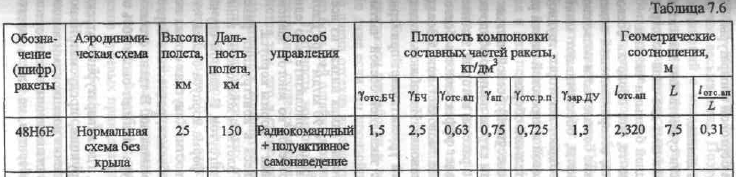

**Прототип 48Н6Е** (С-300ПМУ). Бескрылая нормальная схема (частный случай "нормальной" схемы) - "схема с несущим корпусом". Двигатель разгонно-маршевый однорежимный из высокопрочного алюминиевого сплава (таблица 4.3). 

mz_cy = - 0.02...0.06 для обычной схемы (x_t - x_fa) / L_korp

АД ОУ - рули-элероны выполняют еще и роль стабилизирующих поверхностей, обеспечивающих необходимые запасы статической устойчивости.

* стр. 455 про бескрылую схему можно многое узнать

* стр. 511 про нашу ракету написал Грушин

* стр. 527 про бал проектирование

### 2.1. Центровочный расчет ракеты

In [24]:
# длины отсеков
L1, L2, L3, L4, L5 = 1.360, 1.163, 0.465, 3.853, 0.849

In [52]:
# плотности отсеков
rho1, rho2, rho3, rho5 = 550, 750, 2500, 1200

In [53]:
L_korp = 7690 / 1e3
L_cil = 4567 / 1e3
L_korm = 135 / 1e3
L_oper = 1134 / 1e3
b_0_oper = 1102.3 / 1e3
L_kon1 = 1360 / 1e3
L_kon2 = 1628 / 1e3
x_b_oper = 6501.845766 / 1e3
a = 0.2 # 0.15...0,2
betta_kon2 = 1
d = 515 / 1e3
d_kon1 = d - 2 * np.tan(np.radians(betta_kon2)) * L_kon2
d_kon2 = d_kon1 + 2 * np.tan(np.radians(betta_kon2)) * L2
d_korm = 440 / 1e3
c_oper = 0.03
khi_pk_oper = 50
khi_rul = 90
class_korp = 7
class_oper = 5
S_oper = 1.20092864206
x_ct_0 = 4.5066951078603825
x_ct_marsh = 3.921345267027331

In [54]:
# объемы отсеков
V1 = 1/3 * np.pi * (d_kon1/2)**2 * L_kon1
V2 = 1/3 * np.pi * L2 * ((d_kon1/2)**2 + (d_kon1/2) * (d_kon2/2) + (d_kon2/2)**2)
V3 = 1/3 * np.pi * L3 * ((d_kon2/2)**2 + (d_kon2/2) * (d/2) + (d/2)**2)
V4 = 1/4 * np.pi * d**2 * L4 
V5 = 1/4 * np.pi * d**2 * (L5 - L_korm) + 1/3 * np.pi * L_korm * ((d/2)**2 + (d/2)*(d_korm/2) + (d_korm/2)**2)
V1, V2, V3, V4, V5

(0.07474012762427584,
 0.2092344884749249,
 0.09384174611213834,
 0.8026077490489509,
 0.1729562798379823)

In [55]:
# массы отсеков
Q1, Q2, Q3, Q4, Q5 = rho1 * V1, rho2 * V2, rho3 * V3, w_marsh + α_д * w_marsh, rho5 * V5
Q1, Q2, Q3, Q4, Q5

(41.10707019335172,
 156.92586635619367,
 234.60436528034586,
 1672.8966425279789,
 207.54753580557878)

In [56]:
# масса ракеты
Q1 + Q2 + Q3 + Q4 + Q5

2313.0814801634488

In [57]:
# центры масс отсеков
x_ct1 = 2/3 * L_kon1
r_kon1, r_kon2 = d_kon1/2, d_kon2/2
x_ct2 = L_kon1 + (L2 - L2/4 * ((r_kon2**2 + 2*r_kon1*r_kon2 + 3*r_kon1**2) / (r_kon2**2 + r_kon1*r_kon2 + r_kon1**2)))
x_ct3 = L_kon1 + L2 + (L3 - L3/4 * ((r_kon2**2 + 2*r_kon1*r_kon2 + 3*r_kon1**2) / (r_kon2**2 + r_kon1*r_kon2 + r_kon1**2)))
x_ct4 = L_kon1 + L_kon2 + L4/2
x_ct5 = L_kon1 + L_kon2 + L4 + L5/2
x_ct1, x_ct2, x_ct3, x_ct4, x_ct5

(0.9066666666666667, 1.957937945958474, 2.762072351565512, 4.9145, 7.2655)

In [58]:
# центры масс ракеты в характерных точках
x_ct_0 = (Q1 * x_ct1 + Q2 * x_ct2 + Q3 * x_ct3 + Q4 * x_ct4 + Q5 * x_ct5) / (Q1 + Q2 + Q3 + Q4 + Q5)
x_ct_marsh = (Q1 * x_ct1 + Q2 * x_ct2 + Q3 * x_ct3 + (α_д * w_marsh) * x_ct4 + Q5 * x_ct5) / (Q1 + Q2 + Q3 + (α_д * w_marsh) + Q5)
x_ct_0, x_ct_marsh

(4.63533300175349, 4.193307377274312)

In [59]:
# разбежка центра масс
razbezhka = (x_ct_0 - x_ct_marsh) / L_korp * 100
razbezhka

5.748057535489958

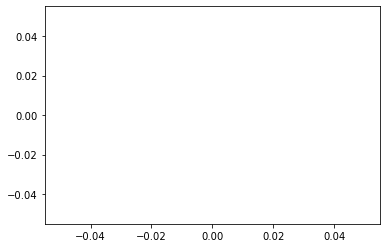

In [60]:
plt.figure()
plt.plot()
plt.show()

### 2.2. Определение АД характеристик на траектории полета полученного профиля скорости

In [61]:
def get_P(t):
    if t < t_marsh:
        return P_marsh
    else:
        return 0

In [62]:
def get_x_ct(t):
    dx_ct = abs(x_ct_0 - x_ct_marsh) / t_marsh
    if t < t_marsh:
        return x_ct_0 - dx_ct * t
    else:
        return x_ct_marsh

In [63]:
def aero_coef(state):
    """
    Ф-ция расчёта аэродинамических коэффициентов ракеты в состоянии state
    arguments: state {np.ndarray} -- состояние ракеты; 
                                     [v,   x, y, Q,       alpha,   t]
                                     [м/с, м, м, радианы, градусы, с]
    return: {dict}                -- словарь с АД коэф-тами 
    """ 
    v, x, y, alpha, t = state[0], state[1], state[2], state[4], state[5] 
    Mach = v / table_atm(y, 4)
    nyu = table_atm(y, 6)
    x_ct = get_x_ct(t)
    Re_korp_f = v * L_korp / nyu
    Re_korp_t = table_4_5(Mach, Re_korp_f, class_korp, L_korp)
    
    
    # Вычисление геометрии корпуса:
    L_nos = L_kon1 #+ L_kon2
    d_kon1 = d - 2 * np.tan(np.radians(betta_kon2)) * L_kon2
    betta_kon1 = (d_kon1 / 2) / L_kon1
    S_kon1 = np.pi * d_kon1**2 / 4
    S_mid = np.pi * d**2 / 4
    S_dno = np.pi * d_korm**2 / 4
    F_f = (np.pi * d_kon1/2 * np.sqrt((d_kon1/2)**2 + L_kon1**2)) + (np.pi * (d_kon1/2 + d/2) * np.sqrt((d/2 - d_kon1/2)**2 + L_kon2**2)) + (np.pi * d * L_cil) + (np.pi * (d_korm/2 + d/2) * np.sqrt((d/2 - d_korm/2)**2 + L_korm**2))
    W_nos = 1/3 * L_kon1 * S_mid + 1/3 * np.pi * L_kon2 * ((d_kon1/2)**2 + (d_kon1/2)*(d/2) + (d/2)**2)
    lambd_korp = L_korp / d
    lambd_nos = L_nos / d
    lambd_cil = L_cil / d
    lambd_korm = L_korm / d
    nu_korm = d_korm / d
    
    
    # Вычисление геометрии рулей (оперения):
    D_oper = d / L_oper
    L_k_oper = L_oper - d
    tg_khi_pk_oper = np.tan(np.radians(khi_pk_oper))
    lambd_oper = L_oper**2 / S_oper
    nu_oper = (S_oper / (L_oper * b_0_oper) - 0.5) ** (-1) / 2
    b_k_oper = b_0_oper / nu_oper
    b_a_oper = 4 / 3 * S_oper / L_oper * (1 - (nu_oper / (nu_oper + 1) ** 2))
    b_b_oper = b_0_oper * (1 - (nu_oper - 1) / nu_oper * d / L_oper)
    z_a_oper = L_oper / 6 * ((nu_oper + 2) / (nu_oper + 1))
    S_k_oper = S_oper * (1 - ((nu_oper - 1) / (nu_oper + 1)) * d / L_oper) * (1 - d / L_oper)
    nu_k_oper = nu_oper - d / L_oper * (nu_oper - 1)
    lambd_k_oper = lambd_oper * ((1 - d / L_oper) / (1 - ((nu_oper - 1) / (nu_oper + 1) * d / L_oper)))
    tg_khi_05_oper = tg_khi_pk_oper - 2 / lambd_oper * (nu_k_oper - 1) / (nu_k_oper + 1)
    a_oper = 2/3 * b_b_oper
    K_oper = 1 / (1 - a_oper / b_a_oper)
    L_hv_oper = L_korp - x_b_oper - b_b_oper
    if tg_khi_pk_oper == 0:
        x_b_a_oper = x_b_oper
    else:
        x_b_a_oper = x_b_oper + (z_a_oper - d / 2) * tg_khi_pk_oper

    
    # Коэф-т подъемной силы корпуса
    if Mach <= 1:
        Cy_alpha_nos = 2 / 57.3 * (1 + 0.27 * Mach**2)
    else:
        Cy_alpha_nos = 2 / 57.3 * (np.cos(np.radians(betta_kon1))**2 * S_kon1 / S_mid
                                   + np.cos(np.radians(betta_kon2))**2 * (1 - S_kon1 / S_mid))
    Cy_alpha_korm = - 2 / 57.3 * (1 - nu_korm ** 2) * a
    Cy_alpha_korp = Cy_alpha_nos + Cy_alpha_korm
    
    
    # Коэф-т подъемной силы оперения по углу атаки
    K_t_oper = table_3_21(Mach, lambd_nos)
    Cy_alpha_k_oper = Cy_alpha_iz_kr(Mach * np.sqrt(K_t_oper), lambd_oper, c_oper, tg_khi_05_oper)
    k_aa_oper = (1 + 0.41 * D_oper)**2 * ((1 + 3 * D_oper - 1 / nu_k_oper * D_oper * (1 - D_oper)) / (1 + D_oper)**2)
    K_aa_oper = 1 + 3 * D_oper - (D_oper * (1 - D_oper)) / nu_k_oper
    Cy_alpha_oper = Cy_alpha_k_oper * K_aa_oper
    
    
    # Коэф-т подъемной силы оперения (рулей) по углу их отклонения
    K_delt_0_oper = k_aa_oper
    k_delt_0_oper = k_aa_oper ** 2 / K_aa_oper
    if Mach <= 1:
        k_shch = 0.825
    elif 1 < Mach <= 1.4:
        k_shch = 0.85 + 0.15 * (Mach - 1) / 0.4
    else:
        k_shch = 0.975
    n_eff = k_shch * np.cos(np.radians(khi_rul))
    Сy_delt_oper = Cy_alpha_k_oper * K_delt_0_oper * n_eff
    
    
    # Коэф-т подъемной силы ракеты
    Cy_alpha = Cy_alpha_korp * (S_mid / S_mid)  + Cy_alpha_oper * (S_oper / S_mid) * K_t_oper    
      
    
    # Сопротивление корпуса
    x_t = Re_korp_t * nyu / v
    x_t_ = x_t / L_korp
    Cx_f_ = table_4_2(Re_korp_f, x_t_) / 2
    nu_m = table_4_3(Mach, x_t_)
    nu_c = 1 + 1 / lambd_nos
    Cx_tr = Cx_f_ * (F_f / S_mid) * nu_m * nu_c
    
    if Mach > 1:
        p_kon1_ = (0.0016 + 0.002 / Mach**2) * betta_kon1**1.7
        p_kon2_ = (0.0016 + 0.002 / Mach**2) * betta_kon2**1.7
        Cx_nos = p_kon1_ * (S_kon1 / S_mid) + p_kon2_ * (1 - (S_kon1 / S_mid))
    else:
        Cx_nos = table_4_11(Mach, lambd_nos)

    Cx_korm = table_4_24(Mach, nu_korm, lambd_korm)
    
    if get_P(t) == 0:
        p_dno_ = table_p_dno_(Mach, oper=True)
        K_nu = table_k_nu(nu_korm, lambd_korm, Mach)
        Cx_dno = p_dno_ * K_nu * (S_dno / S_mid)
    else:
        Cx_dno = 0
    Cx_0_korp = Cx_tr + Cx_nos + Cx_korm + Cx_dno
    
    if Mach < 1:
        phi = -0.2
    else:
        phi = 0.7
    Cx_ind_korp = Cy_alpha_korp * alpha**2 * ((1 + phi) / 57.3)
    
    Cx_korp = Cx_0_korp + Cx_ind_korp
    
    
    # Сопротивление оперения
    Re_oper_f = v * b_a_oper / nyu
    Re_oper_t = table_4_5(Mach, Re_oper_f, class_oper, b_a_oper)
    x_t_oper = Re_oper_t / Re_oper_f
    C_f_oper = table_4_2(Re_oper_f, x_t_oper)
    nu_c_oper = table_4_28(x_t_oper, c_oper)
    Cx_oper_prof = C_f_oper * nu_c_oper
    
    if Mach < 1.1:
        Cx_oper_voln = table_4_30(Mach, nu_k_oper, lambd_oper, tg_khi_05_oper, c_oper)
    else:
        phi = table_4_32(Mach, tg_khi_05_oper)
        Cx_oper_voln = (table_4_30(Mach, nu_k_oper, lambd_oper, tg_khi_05_oper, c_oper)) * (1 + phi * (K_oper - 1))
        
    Cx_0_oper = Cx_oper_prof + Cx_oper_voln
    
    if Mach * np.cos(np.radians(khi_pk_oper)) > 1:
        Cx_ind_oper = (Cy_alpha_oper * alpha) * np.tan(np.radians(alpha))
    else:
        Cx_ind_oper = 0.38 * (Cy_alpha_oper * alpha)**2 / (lambd_oper - 0.8 * (Cy_alpha_oper * alpha) * (lambd_oper - 1)) *\
        ((lambd_oper / np.cos(np.radians(khi_pk_oper)) + 4) / (lambd_oper + 4))
        
    Cx_oper = Cx_0_oper + Cx_ind_oper
    
    Cx_0 = 1.05 * (Cx_0_korp * (S_mid / S_mid) + Cx_0_oper * K_t_oper * (S_oper / S_mid))
    Cx_ind = Cx_ind_korp * (S_mid / S_mid) + Cx_ind_oper * (S_oper / S_mid) * K_t_oper
    Cx = Cx_0 + Cx_ind
    
    
    # Центр давления корпуса
    delta_x_f = F_iz_korp(Mach, lambd_nos, lambd_korp, L_nos)
    x_fa_nos_cil = L_nos - W_nos / S_mid + delta_x_f
    x_fa_korm = L_korp - 0.5 * L_korm   
    x_fa_korp = 1 / Cy_alpha_korp * (Cy_alpha_nos * x_fa_nos_cil + Cy_alpha_korm * x_fa_korm)
    
    
    # Фокус оперения по углу атаки
    x_f_iz_oper_ = F_iz_kr(Mach, lambd_k_oper, tg_khi_05_oper, nu_k_oper)
    x_f_iz_oper = x_b_a_oper + b_a_oper * x_f_iz_oper_
    f1 = table_5_11(D_oper, L_k_oper)
    x_f_delt_oper = x_f_iz_oper - tg_khi_05_oper * f1
    if Mach > 1:
        b__b_oper = b_b_oper / (np.pi / 2 * d * np.sqrt(Mach ** 2 - 1))
        L__hv_oper = L_hv_oper / (np.pi * d * np.sqrt(Mach ** 2 - 1))
        c_const_oper = (4 + 1 / nu_k_oper) * (1 + 8 * D_oper ** 2)
        F_1_oper = 1 - 1 / (c_const_oper * b__b_oper ** 2) * (1 - np.exp(-c_const_oper * b__b_oper ** 2))
        F_oper = 1 - np.sqrt(np.pi) / (2 * b__b_oper * np.sqrt(c_const_oper)) * (table_int_ver((b__b_oper + L__hv_oper) *\
                np.sqrt(2 * c_const_oper)) - table_int_ver(L__hv_oper * np.sqrt(2 * c_const_oper)))
        x_f_b_oper_ = x_f_iz_oper_ + 0.02 * lambd_oper * tg_khi_05_oper
        x_f_ind_oper = x_b_oper + b_b_oper * x_f_b_oper_ * F_oper * F_1_oper
        x_fa_oper = 1 / K_aa_oper * (x_f_iz_oper + (k_aa_oper - 1) * x_f_delt_oper + (K_aa_oper - k_aa_oper) * x_f_ind_oper)
    else:
        x_f_b_oper_ = x_f_iz_oper_ + 0.02 * lambd_oper * tg_khi_05_oper
        x_f_ind_oper = x_b_oper + b_b_oper * x_f_b_oper_
        x_fa_oper = 1 / K_aa_oper * (x_f_iz_oper + (k_aa_oper - 1) * x_f_delt_oper + (K_aa_oper - k_aa_oper) * x_f_ind_oper)

        
    # Фокус оперения по углу отклонения
    x_fd_oper = 1 / K_delt_0_oper * (k_delt_0_oper * x_f_iz_oper + (K_delt_0_oper - k_delt_0_oper) * x_f_ind_oper)
    
    
    # Фокус ракеты
    x_fa = 1 / Cy_alpha * ((Cy_alpha_korp * (S_mid / S_mid) * x_fa_korp) + Cy_alpha_oper * (S_oper / S_mid) * x_fa_oper * K_t_oper)
    
    
    # Демпфирующие моменты АД поверхностей
    x_c_ob = L_korp * ((2 * (lambd_nos + lambd_cil)**2 - lambd_nos**2) / (4 * (lambd_nos + lambd_cil) * (lambd_nos + lambd_cil - 2 / 3 * lambd_nos)))
    m_z_wz_korp = - 2 * (1 - x_ct / L_korp + (x_ct / L_korp) ** 2 - x_c_ob / L_korp)

    x_ct_oper_ = (x_ct - x_b_a_oper) / b_a_oper
    m_z_wz_oper = -57.3 * (Cy_alpha_oper * (x_ct_oper_ - 1 / 2)**2 * K_aa_oper)

    m_z_wz = m_z_wz_korp * (S_mid / S_mid) * (L_korp / L_korp)**2 + m_z_wz_oper * (S_oper / S_mid) * (b_a_oper / L_korp) * np.sqrt(K_t_oper)
    

    # Балансировочная зависимость
    M_z_delt_oper = Сy_delt_oper * (x_ct - x_fd_oper) / L_korp
    M_z_alpha = Cy_alpha * (x_ct - x_fa) / L_korp
    ballans_relation = - (M_z_alpha / M_z_delt_oper)

    
    # Запас статической устойчивости
    m_z_cy = (x_ct - x_fa) / L_korp
    
    
    return {
        'Cy_alpha': Cy_alpha,
        'Cy_alpha_korp': Cy_alpha_korp,
        'Cy_alpha_oper': Cy_alpha_oper,
        'Cx': Cx,
        'Cx_0': Cx_0,
        'Cx_0_korp': Cx_0_korp,
        'Cx_0_oper': Cx_0_oper,
        'Cx_ind': Cx_ind,
        'Cx_ind_korp': Cx_ind_korp,
        'Cx_ind_oper': Cx_ind_oper,
        'x_fa': x_fa,
        'x_fa_korp': x_fa_korp,
        'x_fa_oper': x_fa_oper,
        'x_fd_oper': x_fd_oper,
        'm_z_cy': m_z_cy,
        'm_z_wz': m_z_wz,
        'm_z_wz_korp': m_z_wz_korp,
        'm_z_wz_oper': m_z_wz_oper,
        'ballans_relation': ballans_relation,
        'M_z_alpha': M_z_alpha,
        'M_z_delt_oper': M_z_delt_oper
    }

In [64]:
def foo_aero(solve, alpha):
    result = []
    for i in range(len(res['t'])):
        arg = [res['v'][i], res['x'][i], res['y'][i], res['thetta'][i], alpha, res['t'][i]]
        result.append(aero_coef(arg))
    return result

In [65]:
res_aero = foo_aero(res, alpha=0)

In [66]:
res_aero[-1]

{'Cy_alpha': 0.2192406702210984,
 'Cy_alpha_korp': 0.033016366385328684,
 'Cy_alpha_oper': 0.03250331466959562,
 'Cx': 0.15396967365097436,
 'Cx_0': 0.15396967365097436,
 'Cx_0_korp': 0.1108237770389851,
 'Cx_0_oper': 0.006250923900994684,
 'Cx_ind': 0.0,
 'Cx_ind_korp': 0.0,
 'Cx_ind_oper': 0.0,
 'x_fa': 5.797998916597824,
 'x_fa_korp': -0.14046005545656465,
 'x_fa_oper': 6.850849340238016,
 'x_fd_oper': 6.852656826076926,
 'm_z_cy': -0.20867250186261532,
 'm_z_wz': -23.26903895184845,
 'm_z_wz_korp': -0.3545840650492176,
 'm_z_wz_oper': -28.935381884650464,
 'ballans_relation': -1.0245284672044747e+17,
 'M_z_alpha': -0.04574949916507319,
 'M_z_delt_oper': -4.465420008280018e-19}

In [67]:
arr_mach = res['Mach'][:np.argmax(res['Mach'])+1]
arr_mach

array([0.07350726, 0.11235622, 0.15141408, 0.19068343, 0.23016688,
       0.2698671 , 0.30978677, 0.34992861, 0.39029538, 0.43088987,
       0.47171473, 0.51277246, 0.55406632, 0.59559929, 0.63737436,
       0.67939359, 0.72166   , 0.76417362, 0.80693602, 0.84994239,
       0.89318186, 0.93662714, 0.98022183, 1.02390716, 1.0677475 ,
       1.11177629, 1.1560096 , 1.20045597, 1.24513119, 1.29004283,
       1.33519703, 1.38059334, 1.42623885, 1.47214011, 1.518299  ,
       1.56471803, 1.61140599, 1.65837175, 1.70561888, 1.75315419,
       1.80098459, 1.84910904, 1.89752909, 1.94624869, 1.99527215,
       2.04462037, 2.0942803 , 2.14426335, 2.19458073, 2.24524048,
       2.29623709, 2.34758492, 2.39930121, 2.45137314, 2.50381465,
       2.55662301, 2.60981505, 2.66338668, 2.71735483, 2.77172806,
       2.82650025, 2.88169298, 2.93729284, 2.99333529, 3.0497926 ,
       3.10666946, 3.16395944, 3.22169408, 3.27984916, 3.3384531 ,
       3.39751277, 3.4570335 , 3.5170174 , 3.57747876, 3.63842

In [68]:
arr_cya = []
for i in range(len(arr_mach)):
    arr_cya.append(res_aero[i]['Cy_alpha'])
arr_cya = np.array(arr_cya)
arr_cya

array([0.34047833, 0.34073502, 0.34110246, 0.34158373, 0.34218247,
       0.34290288, 0.34374988, 0.34472918, 0.34606708, 0.34763671,
       0.34940204, 0.35137772, 0.35358163, 0.35603587, 0.35876836,
       0.36181514, 0.36522443, 0.36906305, 0.37342939, 0.37847892,
       0.38458321, 0.3927011 , 0.40479192, 0.4204059 , 0.42741814,
       0.43120085, 0.42907013, 0.42716426, 0.42540505, 0.42374938,
       0.42217052, 0.4197631 , 0.41507701, 0.41050912, 0.40603735,
       0.40164444, 0.3973161 , 0.39304068, 0.38880899, 0.38415554,
       0.37931262, 0.37449751, 0.36970488, 0.36492988, 0.36016821,
       0.3554145 , 0.35066708, 0.34623847, 0.34211023, 0.33797889,
       0.33384334, 0.32970097, 0.32554914, 0.32138773, 0.3172146 ,
       0.31318803, 0.30949079, 0.30578025, 0.30205462, 0.29831273,
       0.29455447, 0.29077789, 0.28698346, 0.28330499, 0.2798547 ,
       0.27638445, 0.27289859, 0.26939498, 0.26587489, 0.26233641,
       0.25877895, 0.25561349, 0.25270051, 0.24977075, 0.24682

In [69]:
data_cya_from_mach = {'Cya': arr_cya, 'Mach': arr_mach} 
df1 = pd.DataFrame(data_cya_from_mach)
df1.to_csv('cya_from_mach.csv', sep = ";", index=False)

In [70]:
df1 = pd.read_csv('cya_from_mach.csv', sep = ";")
df1

,Cya,Mach
0,0.340478,0.073507
1,0.340735,0.112356
2,0.341102,0.151414
3,0.341584,0.190683
4,0.342182,0.230167
...,...,...
113,0.132804,6.508083
114,0.129325,6.599037
115,0.125801,6.691212
116,0.122231,6.784635


In [71]:
arr_alpha = np.arange(-40, 41, 1)
arr_alpha

array([-40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28,
       -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15,
       -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,
        -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40])

In [72]:
arr_cx = []
for i in tqdm(arr_alpha):
    res_aero = foo_aero(res, alpha=i)
    cx_from_mach = []
    for j in range(len(arr_mach)):
        cx_from_mach.append(res_aero[j]['Cx'])
    arr_cx.append(cx_from_mach)
arr_cx = np.array(arr_cx)
arr_cx

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [27:35<00:00, 20.43s/it]


array([[10.28152736, 10.31211896, 10.33126324, ...,  4.763873  ,
         4.64408999,  4.61407573],
       [ 9.80621655,  9.83623418,  9.85455594, ...,  4.50255135,
         4.38984655,  4.36262619],
       [ 9.34133408,  9.37078957,  9.38830576, ...,  4.25151015,
         4.14556335,  4.1210105 ],
       ...,
       [11.3765391 , 11.40977263, 11.43271153, ...,  4.25151015,
         4.14556335,  4.1210105 ],
       [12.00772522, 12.0418313 , 12.06602133, ...,  4.50255135,
         4.38984655,  4.36262619],
       [12.65827417, 12.69328155, 12.71876392, ...,  4.763873  ,
         4.64408999,  4.61407573]])

In [73]:
df2 = pd.DataFrame(arr_cx, columns=arr_mach, index=arr_alpha)
df2.to_csv('cx_from_mach_and_alpha.csv', sep = ";")

In [74]:
df2 = pd.read_csv('cx_from_mach_and_alpha.csv', sep = ";", index_col=0)
df2

,0.07350725518340458,0.11235622302801225,0.15141408224356973,0.19068342779848294,0.2301668834919304,0.2698671035071127,0.30978677403269317,0.3499286149568274,0.3902953816384221,0.4308898728215572,...,6.070391339081016,6.155758890734353,6.242020489964373,6.329689676420385,6.418309980865426,6.508082754866952,6.599036531233458,6.691212235330244,6.784635423997473,6.821519335332183
-40,10.281527,10.312119,10.331263,10.348157,10.369575,10.405084,10.446811,10.495132,10.563311,10.644174,...,5.561835,5.451894,5.340931,5.228202,5.114292,4.998943,4.882117,4.763873,4.644090,4.614076
-39,9.806217,9.836234,9.854556,9.870370,9.890444,9.924331,9.964145,10.010248,10.075297,10.152454,...,5.253414,5.149956,5.045543,4.939467,4.832281,4.723740,4.613810,4.502551,4.389847,4.362626
-38,9.341334,9.370790,9.388306,9.403063,9.421820,9.454118,9.492059,9.535989,9.597973,9.671498,...,4.957404,4.860137,4.761976,4.662253,4.561485,4.459445,4.356099,4.251510,4.145563,4.121011
-37,8.886953,8.915858,8.932586,8.946309,8.963776,8.994520,9.030628,9.072430,9.131413,9.201382,...,4.673302,4.581946,4.489756,4.396099,4.301461,4.205628,4.108568,4.010349,3.910855,3.888850
-36,8.443146,8.471513,8.487470,8.500182,8.516388,8.545610,8.579925,8.619647,8.675694,8.742185,...,4.400644,4.314933,4.228446,4.140581,4.051797,3.961892,3.870835,3.778698,3.685367,3.665794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,10.171561,10.203134,10.223692,10.242453,10.266220,10.304593,10.349739,10.402085,10.476512,10.565015,...,4.400644,4.314933,4.228446,4.140581,4.051797,3.961892,3.870835,3.778698,3.685367,3.665794
37,10.764542,10.796931,10.818659,10.838957,10.864641,10.905328,10.953207,11.008729,11.087686,11.181578,...,4.673302,4.581946,4.489756,4.396099,4.301461,4.205628,4.108568,4.010349,3.910855,3.888850
38,11.376539,11.409773,11.432712,11.454598,11.482265,11.525346,11.576052,11.634858,11.718503,11.817969,...,4.957404,4.860137,4.761976,4.662253,4.561485,4.459445,4.356099,4.251510,4.145563,4.121011
39,12.007725,12.041831,12.066021,12.089550,12.119267,12.164822,12.218451,12.280652,12.369143,12.474373,...,5.253414,5.149956,5.045543,4.939467,4.832281,4.723740,4.613810,4.502551,4.389847,4.362626


## 3) Бал. расчет с помощью более подробной мат. модели